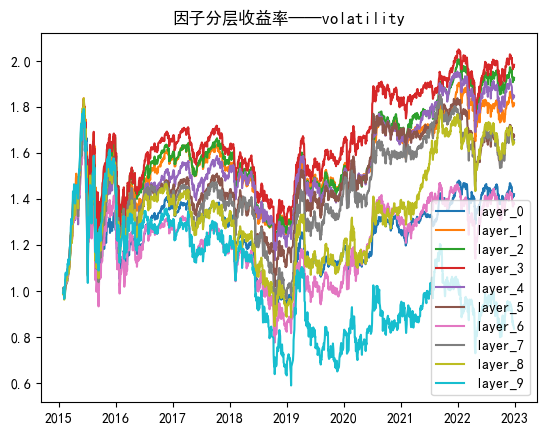

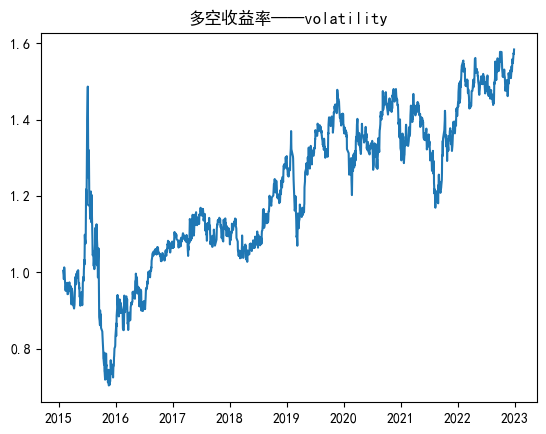

d:\Anaconda\envs\TwentyThree\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Anaconda\envs\TwentyThree\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
d:\Anaconda\envs\TwentyThree\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


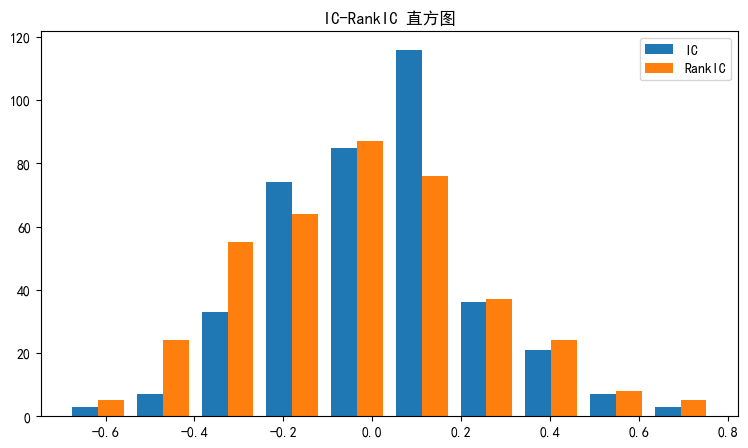

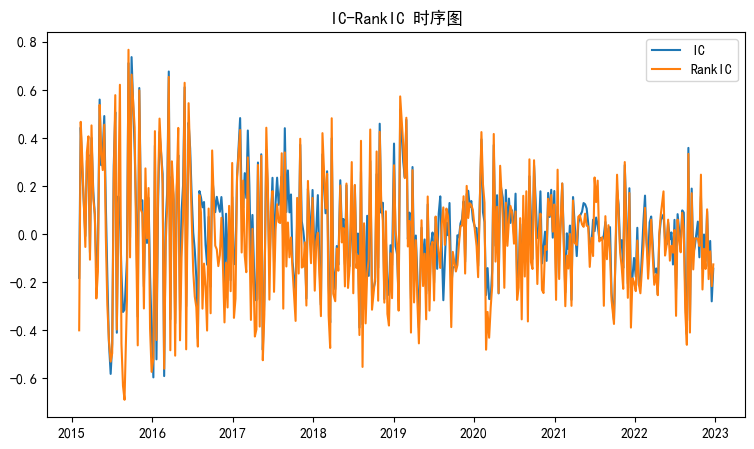

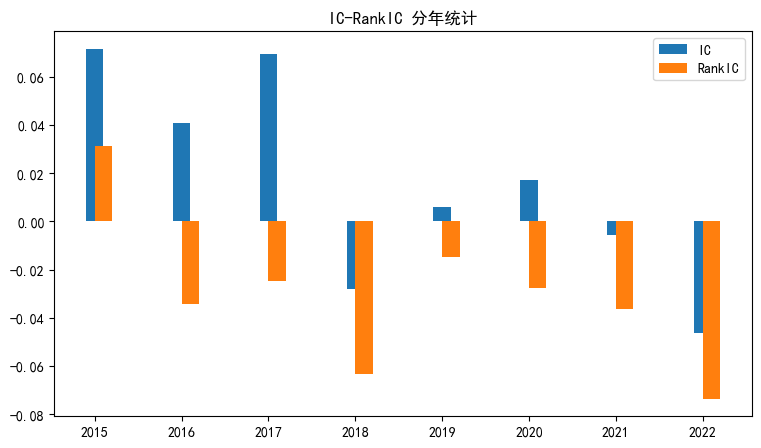

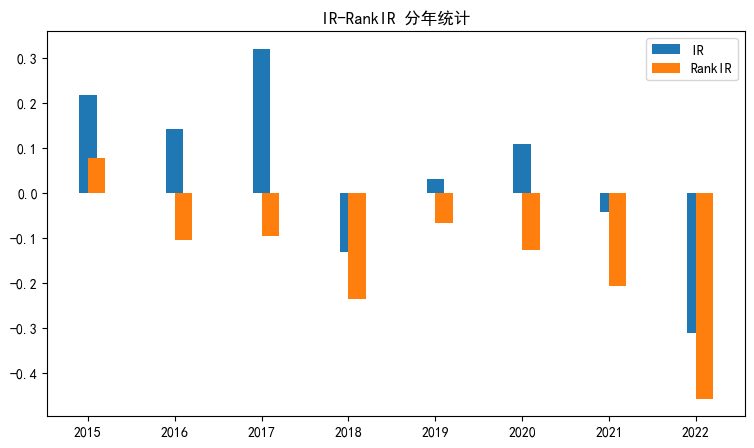

In [2]:
from stock_data import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False
import numpy as np
import copy
from scipy.stats import spearmanr

class Backtester(object):
    def __init__(self):
        pass

    def set_data_obj(self, data_obj):
        self.data_obj = data_obj
        self.date_list = list(self.data_obj.factor_dict['amount'].index)
        self.symbol_list = list(self.data_obj.symbol_list)
        self.factor_name = self.data_obj.decision_factor
        self.factor_path = 'factor_result\\' + self.factor_name +'\\'
        if not os.path.exists(self.factor_path):
            os.makedirs(self.factor_path)

    def set_backtest_para(self, para):
        self.decision_freq = para['decision_freq']   #决策频率
        self.fee = para['fee']                       #手续费

    def backtest_engine(self):
        self.posList = np.zeros((len(self.date_list), len(self.symbol_list)))
        self.hold_days = np.zeros((len(self.date_list), len(self.symbol_list)))
        self.blank_days = np.zeros((len(self.date_list), len(self.symbol_list)))
        self.hold_rtn = np.zeros((len(self.date_list), len(self.symbol_list)))
        self.pre_pos = np.zeros(len(self.symbol_list))
        for k in range(1, len(self.date_list)):
            #调用策略函数
            pos = self.call_strategy(k-1)
            # 计算可实现的交易
            pos_chg_t = pos - self.pre_pos    # 理论持仓变化
            buy_f = self.data_obj.factor_arr_dict['buy_flag'][k]
            sell_f = self.data_obj.factor_arr_dict['sell_flag'][k]
            pos_chg_t[(pos_chg_t < 0) & (sell_f == 0)] = 0
            pos_chg_t[(pos_chg_t > 0) & (buy_f == 0)] = 0
            pos_tmp = self.pre_pos + pos_chg_t
            if pos_tmp.sum() > 1:
                idx_tmp = np.where((pos_chg_t > 0) & (buy_f != 0))[0]
                pos_chg_t[idx_tmp] = pos_chg_t[idx_tmp] - (pos_tmp.sum()-1.0)/len(idx_tmp)
            self.posList[k] = self.pre_pos + pos_chg_t

            #计算个股的持仓天数和持仓收益率
            idx = np.where(self.posList[k]>0)
            self.hold_days[k, idx] = self.hold_days[k - 1, idx] + 1
            self.hold_rtn[k, idx] = (1 + self.hold_rtn[k - 1, idx]) * (1 + self.data_obj.factor_arr_dict['HRTN'][k, idx]) - 1
            self.pre_pos = copy.deepcopy(self.posList[k])
            idx1 = np.where(self.posList[k] == 0)
            self.blank_days[k, idx1] = self.blank_days[k - 1, idx1] + 1

        self.positionDF = pd.DataFrame(self.posList, index=self.date_list, columns=self.symbol_list)
        self.hold_days_DF = pd.DataFrame(self.hold_days, index=self.date_list, columns=self.symbol_list)
        self.hold_rtn_DF = pd.DataFrame(self.hold_rtn, index=self.date_list, columns=self.symbol_list)

        self.turnover = self.positionDF.diff(1).abs().fillna(0)
        self.turnover_ser = self.turnover.sum(axis=1)
        self.compute_pnl()

        self.compute_report()

        self.plot_data()
        a = 1

    def call_strategy(self, k):
        idx = self.data_obj.factor_arr_dict['index_weight'][k] > 0  # 定位当天的指数成分股
        pos_idx = np.where(idx == True)[0]
        if np.mod(k,self.decision_freq) != 0:
            pos = copy.deepcopy(self.pre_pos)
            idx_close = np.where((idx == False))[0]
            pos[idx_close] = 0
            return pos
        else:
            pos = np.zeros(len(self.symbol_list))

        # 准备决策数据并处理异常值
        pe_ttm = self.data_obj.factor_arr_dict[self.data_obj.factor_list[0]][k, idx]
        pe_ttm[np.isnan(pe_ttm)] = 999
        pe_ttm[pe_ttm < 0] = 999
        hold_num = int(len(pe_ttm) * 0.5)

        ridx1 = np.argsort(pe_ttm)
        index1 = np.zeros(len(pe_ttm))
        index1[ridx1] = range(len(pe_ttm))

        index = index1
        idx_trdae = np.argsort(index)[:hold_num]
        target_idx = pos_idx[idx_trdae]

        if len(target_idx) > 0:
            pos[target_idx] = 1.0/len(target_idx)
        return pos

    # 因子IC分析
    def factor_ananlyse_ic(self):
        rtn_lenght = 5
        ic_date_list = []
        for k in range(1, len(self.date_list)-rtn_lenght, rtn_lenght):
            factor_arr = self.data_obj.factor_arr_dict[self.factor_name][k, :]
            idx = ~np.isnan(factor_arr)
            factor_arr = factor_arr[idx]
            rtn_arr = np.array(self.data_obj.factor_dict['HRTN'].loc[:,idx].iloc[k+1:k+rtn_lenght, :].sum(0))
            corr = np.corrcoef(factor_arr, rtn_arr)
            correlation, p_value = spearmanr(factor_arr, rtn_arr)
            ic_date_list.append([self.date_list[k], corr[0,1], correlation])

        ic_df = pd.DataFrame(ic_date_list, columns=['date','IC','RankIC'])
        ic_df.set_index('date',inplace=True)
        year_list = list(range(ic_df.index[0].year,ic_df.index[-1].year+1))
        year_ic_list = []
        for year in year_list:
            this_ic_df = ic_df.loc[str(year), :]
            year_ic_list.append([str(year)] + list(this_ic_df.mean())+ list(this_ic_df.mean()/this_ic_df.std()) )
        year_ic_df = pd.DataFrame(year_ic_list, columns=['year','IC','RankIC','IR','RankIR'])
        ## 绘图
        plt.figure(figsize=(9, 5))
        plt.title('IC-RankIC 直方图')
        plt.hist(ic_df)
        plt.legend(['IC','RankIC'])
        # plt.show()
        plt.savefig(self.factor_path+ '\\IC_series.png')
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.title('IC-RankIC 时序图')
        plt.plot(ic_df)
        plt.legend(['IC', 'RankIC'])
        # plt.show()
        plt.savefig(self.factor_path + '\\IC_hist.png')
        plt.show()

        year_ic_df.index = year_ic_df['year']
        plt.figure(figsize=(9, 5))
        plt.title('IC-RankIC 分年统计')
        plt.bar(year_ic_df.index, year_ic_df['IC'], align='center', width=0.2)
        plt.bar(year_ic_df.index, year_ic_df['RankIC'], align='edge', width=0.2)
        plt.legend(['IC', 'RankIC'])
        # plt.show()
        plt.savefig(self.factor_path + '\\IC_year.png')
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.title('IR-RankIR 分年统计')
        plt.bar(year_ic_df.index, year_ic_df['IR'], align='center', width=0.2)
        plt.bar(year_ic_df.index, year_ic_df['RankIR'], align='edge', width=0.2)
        plt.legend(['IR', 'RankIR'])
        # plt.show()
        plt.savefig(self.factor_path + '\\IR_year.png')
        plt.show()
        a = 1

    # 因子分层分析
    def factor_ananlyse_group(self):
        layer_rtn = pd.DataFrame(0., index=self.date_list, columns=list(range(10)))
        ls_rtn_list = []
        date_list = []
        for k in range(1, len(self.date_list)-1):
            idx = self.data_obj.factor_arr_dict['index_weight'][k] > 0
            factor_arr = self.data_obj.factor_dict[self.factor_name].iloc[k, idx]
            if len(factor_arr) == 0:
                continue
            rtn_arr = self.data_obj.factor_dict['HRTN'].iloc[k + 1, idx]
            idx2 = ~np.isnan(factor_arr)
            factor_arr = factor_arr[idx2]
            rtn_arr = rtn_arr[idx2]

            # 分层
            factor_arr.drop_duplicates(inplace=True)
            factor_df_layers = pd.qcut(factor_arr, 10, labels=False, duplicates='drop')
            factor_df_layers.dropna(inplace=True)
            if factor_df_layers is None or len(factor_df_layers) == 0:
                continue
            date_list.append(self.date_list[k])
            # 合并分层结果和收益率
            merged_df = pd.concat([factor_df_layers, rtn_arr], axis=1)
            merged_df.columns = ['layer', 'return']
            avg_returns_by_layer = merged_df.groupby('layer').mean()
            avg_returns_by_layer.index = avg_returns_by_layer.index.astype(int)
            layer_count = merged_df.groupby('layer').count()
            layer_rtn.iloc[k, avg_returns_by_layer.index] = avg_returns_by_layer.iloc[:, 0]
            ls_rtn_list.append(avg_returns_by_layer.iloc[0] - avg_returns_by_layer.iloc[-1])

        plt.title('因子分层收益率——'+ self.factor_name)
        layer_nav = layer_rtn.cumsum() + 1
        plt.plot(pd.DataFrame(layer_nav, index=date_list))
        plt.legend(['layer_' + str(x) for x in range(10)])
        plt.savefig(self.factor_path + '\\layer_rtn.png')
        plt.show()


        plt.title('多空收益率——'+self.factor_name)
        ls_nav = np.array(ls_rtn_list).cumsum() + 1
        plt.plot(pd.Series(ls_nav,index=date_list))
        plt.savefig(self.factor_path + '\\ls_rtn.png')
        plt.show()
        a = 1

    # 因子共线性分析
    def factor_analyse_corr(self):
        ser_list = []
        for factor in self.data_obj.factor_list:
            df = self.data_obj.factor_dict[factor]
            ser_list.append(df.stack())
        stack_df = pd.concat(ser_list,axis=1)
        stack_df.dropna(inplace=True)
        stack_df.columns = self.data_obj.factor_list
        corr = stack_df.corr()
        corr.columns = self.data_obj.factor_list
        corr.index = self.data_obj.factor_list

        # 绘制相关系数矩阵热力图
        import seaborn as sns
        import matplotlib.pyplot as plt

        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.show()

        from statsmodels.stats.outliers_influence import variance_inflation_factor
        # 进行因子共线性分析
        vif = pd.DataFrame()
        vif["Features"] = self.data_obj.factor_list
        vif["VIF"] = [variance_inflation_factor(stack_df.values, i) for i in range(stack_df.shape[1])]

        print(vif)

        # 使用正交化方法消除共线性
        from sklearn.decomposition import PCA
        pca = PCA(n_components=stack_df.shape[1])
        orthogonal_factors = pca.fit_transform(stack_df)
        orthogonal_df = pd.DataFrame(orthogonal_factors, columns=stack_df.columns)
        corr2 = orthogonal_df.corr()
        pass


    #  PE_ttm and int_to_talcap
    def call_strategy_2(self, k):
        idx = self.data_obj.factor_arr_dict['index_weight'][k] > 0  # 定位当天的指数成分股
        pos_idx = np.where(idx == True)[0]
        if np.mod(k,self.decision_freq) != 0:
            pos = copy.deepcopy(self.pre_pos)
            idx_close = np.where((idx == False))[0]
            pos[idx_close] = 0
            return pos
        else:
            pos = np.zeros(len(self.symbol_list))

        # 准备决策数据并处理异常值
        pe_ttm = self.data_obj.factor_arr_dict['pe_ttm'][k, idx]
        int_to_talcap = self.data_obj.factor_arr_dict['int_to_talcap'][k, idx]
        pe_ttm[np.isnan(pe_ttm)] = 999
        pe_ttm[pe_ttm < 0] = 999
        int_to_talcap[np.isnan(int_to_talcap)] = 999
        int_to_talcap[int_to_talcap < 0] = 999

        hold_num = int(len(pe_ttm) * 0.1)
        # hold_num = 20
        ridx1 = np.argsort(pe_ttm)
        index1 = np.zeros(len(pe_ttm))
        index1[ridx1] = range(len(pe_ttm))

        ridx2 = np.argsort(int_to_talcap)
        index2 = np.zeros(len(pe_ttm))
        index2[ridx2] = range(len(pe_ttm))

        index = index1 + index2
        idx_trdae = np.argsort(index)[:hold_num]
        target_idx = pos_idx[idx_trdae]

        if len(target_idx) > 0:
            pos[target_idx] = 1.0/len(target_idx)
        return pos

    def compute_pnl(self):
        arr_pos_L = copy.deepcopy(self.posList)
        arr_pos_L[arr_pos_L <= 0] = 0

        # 将交易拆分成开仓，平仓，持仓 3种情况
        pos_shift = np.insert(arr_pos_L[:-1, :], 0, np.zeros_like(arr_pos_L[0]), axis=0)
        pos_diff = np.insert(np.diff(arr_pos_L, axis=0), 0, arr_pos_L[0], axis=0)
        pos_LB = copy.deepcopy(pos_diff)
        pos_LS = copy.deepcopy(pos_diff)
        pos_LB[pos_LB < 0] = 0
        pos_LS[pos_LS > 0] = 0
        pos_LH = pos_shift
        pos_LH[pos_LH >= arr_pos_L] = arr_pos_L[pos_LH >= arr_pos_L]

        PRtnHold = pos_LH * self.data_obj.factor_arr_dict['HRTN']
        PRtnBuy = pos_LB * (self.data_obj.factor_arr_dict['ORTN'] - self.fee)
        PRtnSell = -1 * pos_LS * (self.data_obj.factor_arr_dict['CRTN'] - self.fee)

        PRtnTotal = PRtnHold + PRtnBuy + PRtnSell
        self.PRtnTotal = pd.DataFrame(PRtnTotal, index=self.date_list, columns=self.symbol_list)
        self.pnl = self.PRtnTotal.sum(1)

        self.trade_fee = (np.abs(pos_LB) + np.abs(pos_LS))* self.fee
        self.trade_fee_ser = self.trade_fee.sum(1)
        a = 1

    def compute_report(self):
        self.report = pd.DataFrame(
            columns=['tradeDays', 'totalRtn', 'YearlyRtn', 'YearlyVol', 'Maxdd', 'Sharp', 'Calmar',
                     'indexRtn', 'totalRtn_excess', 'yearlyRtn_excess', 'yearlyVol_excess', 'maxDD_excess', 'sharp_excess',
                     'calmar_excess', 'Turnover'])

        pnl_year = self.pnl.resample('A').sum()

        self.index_pnl = self.data_obj.index_daily['pct_chg'].loc[self.date_list]

        for y in pnl_year.index:
            self.report.loc[str(y.year), :] = self.computeIndicator(self.pnl[str(y.year)], self.index_pnl[str(y.year)], np.array(self.turnover[str(y.year)]))
        self.report.loc['Total', :] = self.computeIndicator(self.pnl, self.index_pnl, np.array(self.turnover))
        self.hold_num = self.positionDF.apply(np.sign).sum(axis=1)
        self.hold_pct = self.positionDF.sum(axis=1)
        self.nav = (self.pnl + 1).cumprod()
        self.index_nav = (self.index_pnl + 1).cumprod()
        self.excess_nav = (self.pnl - self.index_pnl + 1).cumprod()

        self.report_show = self.report.loc[:,[ 'totalRtn', 'indexRtn','totalRtn_excess', 'YearlyVol', 'Maxdd', 'Sharp', 'Calmar', 'Turnover']]
        self.report_show.columns = ['策略收益率','基准收益率','超额收益率', '波动率', '最大回撤', '夏普', '卡玛', '换手率']
        self.report_show = self.report_show.round(3)
        pd.set_option('display.float_format', '{:.3f}'.format)
        self.report_show.to_excel('report.xlsx')

    def computeIndicator(self, dailyPnl, pnl_index, turnover):
        try:
            startDate = dailyPnl.loc[dailyPnl != 0].index[0]
            startIdx = list(dailyPnl.index).index(startDate)
            dailyPnl = dailyPnl.iloc[startIdx:]
        except:
            pass

        tradeDays = dailyPnl.shape[0]
        totalRtn = (dailyPnl + 1).cumprod()[-1] - 1

        yearlyRtn = np.power(1 + totalRtn, 240.0 / tradeDays) - 1

        yearlyVol = dailyPnl.std() * np.sqrt(240)

        nav = (dailyPnl + 1).cumprod()
        tmpnav = np.maximum.accumulate(nav) - nav
        idx_e = tmpnav.idxmax()
        try:
            idx_s = nav[:idx_e].idxmax()
            maxDD = -(nav[idx_e] - nav[idx_s]) / nav[idx_s]
        except:
            maxDD = 0.0

        if yearlyVol == 0.0:
            sharp = 0.0
        else:
            sharp = yearlyRtn / yearlyVol
        if maxDD == 0.0:
            calmar = 0.0
        else:
            calmar = yearlyRtn / maxDD

        indexRtn = (pnl_index + 1).cumprod()[-1] - 1
        excessDaily = dailyPnl - pnl_index
        excessDaily.fillna(0,inplace=True)
        totalRtn_excess = (excessDaily + 1).cumprod()[-1] - 1
        yearlyRtn_excess =  np.power(1 + totalRtn_excess, 240.0 / tradeDays) - 1
        yearlyVol_excess = excessDaily.std() * np.sqrt(240)

        navExcess = (excessDaily + 1).cumprod()
        tmpnav = np.maximum.accumulate(navExcess) - navExcess
        idx_e = tmpnav.idxmax()
        try:
            idx_s = navExcess[:idx_e].idxmax()
            maxDD_excess = -(navExcess[idx_e] - navExcess[idx_s]) / navExcess[idx_s]
        except:
            maxDD_excess = 0.0

        if yearlyVol_excess == 0.0:
            sharp_excess = 0.0
        else:
            sharp_excess = yearlyRtn_excess / yearlyVol_excess
        if maxDD == 0.0:
            calmar_excess = 0.0
        else:
            calmar_excess = yearlyRtn_excess / maxDD

        return [tradeDays, totalRtn, yearlyRtn,  yearlyVol, maxDD, sharp, calmar,
                indexRtn, totalRtn_excess, yearlyRtn_excess,  yearlyVol_excess, maxDD_excess, sharp_excess, calmar_excess,
                turnover.sum() / tradeDays /2]

    def plot_data(self):
        nav_df = pd.DataFrame(zip(self.nav, self.index_nav, self.excess_nav))
        plt.figure(figsize=(9, 5))
        plt.plot(self.date_list, nav_df, linewidth=2)
        # plt.xlabel('对数收益率')
        plt.ylabel('累计净值')
        plt.grid(True)
        plt.legend(['策略','基准','超额'])
        plt.show()

        pnl_year = self.pnl.resample('A').sum()
        pnl_index_year = self.index_pnl.resample('A').sum()
        year_rtn_df = pd.DataFrame(zip(pnl_year,pnl_index_year),index=[x.year for x in pnl_year.index ])
        plt.figure(figsize=(9, 5))
        year_rtn_df.plot.bar()
        plt.ylabel('年度收益率')
        plt.grid(True)
        plt.legend(['策略','基准'])
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.subplot(211)
        plt.plot(self.hold_num)
        plt.ylabel('持仓数量')
        plt.subplot(212)
        plt.plot(self.hold_pct*100)
        plt.ylabel('持仓比例（%）')
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.subplot(211)
        plt.plot(self.turnover_ser *100)
        plt.ylabel('日换手率（%）')
        plt.subplot(212)
        plt.plot(self.trade_fee_ser)
        # plt.plot(np.cumsum(self.trade_fee_ser))
        plt.ylabel('手续费')
        plt.show()
        a = 1


if __name__ == '__main__':
    factor_list= ['volatility']
    data_obj = StockData()
    data_obj.set_index('000905.SH')
    data_obj.set_date('2015-01-01', '2022-12-30')
    data_obj.set_factor_list(factor_list)
    data_obj.load_index_data()
    data_obj.load_factor_data()
    # data_obj.cumpute_deri_factor()
    data_obj.set_decision_factor(factor_list[0])

    bkt_obj = Backtester()
    bkt_obj.set_data_obj(data_obj)
    bkt_obj.set_backtest_para({'decision_freq': 5,'fee':0.001})
    # bkt_obj.factor_analyse_corr()

    bkt_obj.factor_ananlyse_group()
    bkt_obj.factor_ananlyse_ic()
    # bkt_obj.backtest_engine()
    a = 1